In [27]:
import requests
import urllib3
import pandas as pd
import json

json_file_path = '/Users/erwan/JupyterProjects/strava_project/credentials/credentials.json'

with open(json_file_path, "r") as f:
    credentials = json.load(f)
    
client_id = credentials['client_id']
client_secret = credentials['client_secret']
refresh_token = credentials['refresh_token']

urllib3.disable_warnings()

In [28]:
# API strava's URL
auth_url = 'https://www.strava.com/oauth/token'

# connection to the API of Strava
def connect_strava_api(url):
    
    # auth params
    payload = {
        'client_id':client_id,
        'client_secret':client_secret,
        'refresh_token':refresh_token,
        'grant_type':'refresh_token',
        'f':'json'
    }
    
    print('Requesting the token...\n')
    
    # request the new access token through refresh_token
    res = requests.post(auth_url, data=payload, verify=False)
    access_token = res.json()['access_token']
    
    print('Access token: {}\n'.format(access_token))
    
    return access_token
access_token = connect_strava_api(auth_url)

Requesting the token...

Access token: 2cc58efbae8fa7a0c5cfa190b4f61d71dafc16dc



In [4]:
# url to request data of activities logged athlete 
activities_url = 'https://www.strava.com/api/v3/athlete/activities'

def get_strava_activities(data_url):
        
    request_page_num = 1
    all_activities = []
    
    # get all pages to be sure to have all activities
    while True:
        headers = {'Authorization': 'Bearer ' + access_token}
        params = {'per_page': 200, 'page': request_page_num}

        my_dataset = requests.get(data_url,headers = headers, params = params).json()
        
        # if activities == 0 in the page, then break the loop 
        if len(my_dataset) == 0:
            print('Activities are fully added!')
            break
            
        # add each activity to the list
        if all_activities:
            all_activities.extend(my_dataset)
        else:
            all_activities = my_dataset
        
        request_page_num += 1
    
    print('Number of activities registered: {}\n'.format(len(all_activities)))
    
    # sort activities and transform to dataframe
    sorted_activities = all_activities[::-1]
    df = pd.DataFrame(sorted_activities)
    
    display(df)
    return df

df_activities = get_strava_activities(activities_url)

Activities are fully added!
Number of activities registered: 368



,resource_state,athlete,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,...,upload_id_str,external_id,from_accepted_tag,pr_count,total_photo_count,has_kudoed,suffer_score,average_watts,kilojoules,device_watts
0,2,"{'id': 36334506, 'resource_state': 1}",Night Run,5851.9,2072,291557,15.6,Run,Run,NaN,...,2140930086,garmin_push_3142419849,False,0,0,False,68.0,NaN,NaN,NaN
1,2,"{'id': 36334506, 'resource_state': 1}",Evening Run,6501.4,2294,2434,15.5,Run,Run,NaN,...,2140930087,garmin_push_3174660568,False,0,0,False,45.0,NaN,NaN,NaN
2,2,"{'id': 36334506, 'resource_state': 1}",Lunch Run,6627.0,2380,2396,15.9,Run,Run,NaN,...,2140930088,garmin_push_3176056246,False,1,0,False,83.0,NaN,NaN,NaN
3,2,"{'id': 36334506, 'resource_state': 1}",Evening Run,5000.3,1904,2025,12.8,Run,Run,NaN,...,2140930083,garmin_push_3178619560,False,4,0,False,57.0,NaN,NaN,NaN
4,2,"{'id': 36334506, 'resource_state': 1}",Lunch Run,7741.6,2422,2433,21.2,Run,Run,NaN,...,2140930084,garmin_push_3188644460,False,7,0,False,75.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,2,"{'id': 36334506, 'resource_state': 1}",Morning Trail Run,12412.5,6691,6733,456.2,Run,TrailRun,NaN,...,12053853869,garmin_ping_336708730802,False,0,0,False,126.0,NaN,NaN,NaN
364,2,"{'id': 36334506, 'resource_state': 1}",Lunch Trail Run,12510.8,14947,20489,367.8,Run,TrailRun,NaN,...,12057534430,garmin_ping_336795109492,False,0,0,False,14.0,NaN,NaN,NaN
365,2,"{'id': 36334506, 'resource_state': 1}",Afternoon Run,8191.7,3444,3490,212.8,Run,Run,NaN,...,12073343830,garmin_ping_337278621696,False,0,0,False,13.0,NaN,NaN,NaN
366,2,"{'id': 36334506, 'resource_state': 1}",Lunch Trail Run,4786.2,4882,5214,452.6,Run,TrailRun,NaN,...,12081016992,garmin_ping_337474329300,False,0,0,False,20.0,NaN,NaN,NaN


In [5]:
# filter to run activities
df_activities = df_activities[df_activities['type'] == 'Run']
print('Number of run activity: {}'. format(len(df_activities)))

# get list of ids for future requests
lst_id_activities = [activity.get('id') for activity in df_activities.to_dict(orient='records')]
print('Number of id activities: {}'.format(len(lst_id_activities)))

Number of run activity: 214
Number of id activities: 214


In [6]:
import time

# build the request link from list of ids
lst_link_zones_activities = ['https://www.strava.com/api/v3/activities/' + str(ids) + '/zones' for ids in lst_id_activities]
print('Numbers of links to treat: {}'.format(len(lst_link_zones_activities)))

Numbers of links to treat: 214


In [7]:
# get data of each activity
def get_strava_zones_activities(data_url, ids):
    headers = {'Authorization': 'Bearer ' + access_token}
    my_dataset = requests.get(data_url, headers=headers).json()
    
    df = pd.DataFrame(my_dataset)
    
    # Add a new column for IDs
    df.insert(0, 'id', ids)
    
    return df

all_zones_activities = []
num_activities = 0

# break the loop each 90 activities because of api constraint
for link, ids in zip(lst_link_zones_activities, lst_id_activities):
    if num_activities == 90:
        print('activities are added, waiting 16 min to continue\n')      
        num_activities = 0
        time.sleep(960)
    else:
        # append data activities to a new list
        zone_activities_df = get_strava_zones_activities(link, ids)
        all_zones_activities.append(zone_activities_df)
        
        num_activities += 1
        print('Number of iteration {0}\r'.format(num_activities), end='', flush=True)

# concat each list 
final_df = pd.concat(all_zones_activities, ignore_index=True)
print('Length of the final df: {}'.format(len(final_df)))

activities are added, waiting 16 min to continue

activities are added, waiting 16 min to continue

Length of the final df: 395


In [8]:
# filter on actionable data
final_df = final_df[final_df['type'] == 'heartrate']
print('Length of the actionable df: {}'.format(len(final_df)))

Length of the actionable df: 205


In [9]:
final_df.iloc[1]

id                                                             2002867790
score                                                                45.0
distribution_buckets    [{'min': 0, 'max': 120, 'time': 48}, {'min': 1...
type                                                            heartrate
resource_state                                                        3.0
sensor_based                                                         True
points                                                                6.0
custom_zones                                                        False
Name: 1, dtype: object

In [10]:
lst_zones = []

# get zones of intensity from final_df
for x in range(len(final_df)):
     zones = final_df.iloc[x].iloc[2]
     lst_zones.append(zones)

# rename columns
df_zones = pd.DataFrame(lst_zones)
df_zones.rename(columns={0: 'Zone 1',1: 'Zone 2',2: 'Zone 3',3: 'Zone 4',4: 'Zone 5'}, inplace=True)

# get only time by zones for each zones
for x in range(len(df_zones)):
    for j in range(1, len(df_zones.columns) + 1):
        df_zones.loc[x, 'Zone ' + str(j)] = df_zones.loc[x, 'Zone ' + str(j)]['time']

# transform id list in df
df_id = pd.DataFrame({'id':final_df['id']}).reset_index()

# concat id values with df_zones
result = pd.concat([df_id,df_zones], axis=1)
result.drop(columns=['index'], inplace=True)
result

,id,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5
0,2002867793,21,409,1089,491,62
1,2002867790,48,1119,774,331,0
2,2002867807,18,220,1375,735,24
3,2002867788,10,329,1204,347,0
4,2002867794,23,464,1043,884,8
...,...,...,...,...,...,...
200,11283321967,3,160,2780,3097,41
201,11286914386,6763,0,0,0,0
202,11302270681,1378,1731,331,0,0
203,11309723351,815,719,1478,17,0


In [11]:
# merge zones_df with final_df
full_df = pd.merge(result, df_activities, on='id', how='left')
full_df

,id,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5,resource_state,athlete,name,distance,...,upload_id_str,external_id,from_accepted_tag,pr_count,total_photo_count,has_kudoed,suffer_score,average_watts,kilojoules,device_watts
0,2002867793,21,409,1089,491,62,2,"{'id': 36334506, 'resource_state': 1}",Night Run,5851.9,...,2140930086,garmin_push_3142419849,False,0,0,False,68.0,NaN,NaN,NaN
1,2002867790,48,1119,774,331,0,2,"{'id': 36334506, 'resource_state': 1}",Evening Run,6501.4,...,2140930087,garmin_push_3174660568,False,0,0,False,45.0,NaN,NaN,NaN
2,2002867807,18,220,1375,735,24,2,"{'id': 36334506, 'resource_state': 1}",Lunch Run,6627.0,...,2140930088,garmin_push_3176056246,False,1,0,False,83.0,NaN,NaN,NaN
3,2002867788,10,329,1204,347,0,2,"{'id': 36334506, 'resource_state': 1}",Evening Run,5000.3,...,2140930083,garmin_push_3178619560,False,4,0,False,57.0,NaN,NaN,NaN
4,2002867794,23,464,1043,884,8,2,"{'id': 36334506, 'resource_state': 1}",Lunch Run,7741.6,...,2140930084,garmin_push_3188644460,False,7,0,False,75.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,11283321967,3,160,2780,3097,41,2,"{'id': 36334506, 'resource_state': 1}",Morning Trail Run,12412.5,...,12053853869,garmin_ping_336708730802,False,0,0,False,126.0,NaN,NaN,NaN
201,11286914386,6763,0,0,0,0,2,"{'id': 36334506, 'resource_state': 1}",Lunch Trail Run,12510.8,...,12057534430,garmin_ping_336795109492,False,0,0,False,14.0,NaN,NaN,NaN
202,11302270681,1378,1731,331,0,0,2,"{'id': 36334506, 'resource_state': 1}",Afternoon Run,8191.7,...,12073343830,garmin_ping_337278621696,False,0,0,False,13.0,NaN,NaN,NaN
203,11309723351,815,719,1478,17,0,2,"{'id': 36334506, 'resource_state': 1}",Lunch Trail Run,4786.2,...,12081016992,garmin_ping_337474329300,False,0,0,False,20.0,NaN,NaN,NaN


In [12]:
# count na values
na_values = full_df.isna().sum()
na_values

id                                 0
Zone 1                             0
Zone 2                             0
Zone 3                             0
Zone 4                             0
Zone 5                             0
resource_state                     0
athlete                            0
name                               0
distance                           0
moving_time                        0
elapsed_time                       0
total_elevation_gain               0
type                               0
sport_type                         0
workout_type                     163
start_date                         0
start_date_local                   0
timezone                           0
utc_offset                         0
location_city                    205
location_state                   205
location_country                  16
achievement_count                  0
kudos_count                        0
comment_count                      0
athlete_count                      0
p

In [13]:
# count null values
null_values = full_df.isnull().sum()
null_values

id                                 0
Zone 1                             0
Zone 2                             0
Zone 3                             0
Zone 4                             0
Zone 5                             0
resource_state                     0
athlete                            0
name                               0
distance                           0
moving_time                        0
elapsed_time                       0
total_elevation_gain               0
type                               0
sport_type                         0
workout_type                     163
start_date                         0
start_date_local                   0
timezone                           0
utc_offset                         0
location_city                    205
location_state                   205
location_country                  16
achievement_count                  0
kudos_count                        0
comment_count                      0
athlete_count                      0
p

In [14]:
full_df.describe()

,id,resource_state,distance,moving_time,elapsed_time,total_elevation_gain,workout_type,utc_offset,achievement_count,kudos_count,...,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,pr_count,total_photo_count,suffer_score,average_watts,kilojoules
count,2.050000e+02,205.0,205.000000,205.000000,205.000000,205.000000,42.000000,205.000000,205.000000,205.000000,...,205.000000,205.000000,198.000000,198.000000,2.050000e+02,205.000000,205.000000,205.000000,0.0,0.0
mean,8.083209e+09,2.0,7944.218537,4130.609756,6212.570732,162.207317,0.047619,-7480.975610,3.039024,4.219512,...,138.091220,163.248780,252.561616,130.512121,8.643420e+09,1.365854,0.078049,49.546341,NaN,NaN
std,3.465075e+09,0.0,3827.894026,3275.818608,20473.808026,249.636915,0.215540,9587.035723,5.432152,2.728860,...,22.566897,18.876834,385.746468,264.087439,3.711152e+09,3.201992,0.375416,46.516011,NaN,NaN
min,2.002868e+09,2.0,34.600000,29.000000,35.000000,0.000000,0.000000,-14400.000000,0.000000,0.000000,...,76.500000,81.000000,0.000000,-3.400000,2.140930e+09,0.000000,0.000000,0.000000,NaN,NaN
25%,5.453034e+09,2.0,5589.000000,2470.000000,2639.000000,14.600000,0.000000,-14400.000000,0.000000,2.000000,...,132.000000,152.000000,28.600000,9.425000,5.805513e+09,0.000000,0.000000,17.000000,NaN,NaN
50%,9.732481e+09,2.0,7339.800000,3132.000000,3315.000000,50.800000,0.000000,-14400.000000,1.000000,4.000000,...,144.600000,168.000000,60.200000,20.000000,1.043425e+10,0.000000,0.000000,39.000000,NaN,NaN
75%,1.088279e+10,2.0,10012.000000,4297.000000,4703.000000,225.200000,0.000000,3600.000000,4.000000,6.000000,...,152.700000,176.000000,247.625000,39.500000,1.163197e+10,1.000000,0.000000,70.000000,NaN,NaN
max,1.131453e+10,2.0,28439.000000,26137.000000,291557.000000,2409.800000,1.000000,7200.000000,35.000000,14.000000,...,178.600000,199.000000,1461.500000,976.200000,1.208596e+10,26.000000,3.000000,357.000000,NaN,NaN


In [15]:
import folium
import polyline
from gpxplotter import read_gpx_file
from folium import plugins

# create strava map
map_strava = folium.Map(location=[16.033612195704787,-61.72271466476438], zoom_start=11)

def get_latlong_from_gpx(file_link):
# open and read gpx file
    gpx_file = read_gpx_file(file_link)
    df_gpx = pd.DataFrame(gpx_file)
    
    # get latitude and longitude from df
    latlon_gpx = df_gpx['segments'][0][0]['latlon']
    list_latlon = [[lat, lon] for lat, lon in latlon_gpx]

    return list_latlon

list_latlon = get_latlong_from_gpx('/Users/erwan/JupyterProjects/strava_project/doc/gpx/TDC 2024 - Grand parcours.gpx')
list_latlon2 =  get_latlong_from_gpx('/Users/erwan/JupyterProjects/strava_project/doc/gpx/Trail_du_caf_2023.gpx')

# add coordinates to the map
folium.plugins.PolyLineOffset(locations=list_latlon, color='#0D19FF').add_to(map_strava)
folium.plugins.PolyLineOffset(locations=list_latlon2, color='#952CF1').add_to(map_strava)

# get Polyline from df and plot the route on a map 
def show_strava_map(df):
        
    polylines_activities = []
    
    # get all polylines from df
    for num in range(len(df)):
        df_polyline = df['map'].iloc[num]
        polylines_activities.append(df_polyline['summary_polyline'])

    clean_polyline = [ele for ele in polylines_activities if ele != '']
    
    activities_coords = []
    
    # decode each polyline to get coordinates
    for num in range(len(clean_polyline)):
        coord = polyline.decode(clean_polyline[num], 5)
        activities_coords.append(coord)
    
    # plot coords on a map
    for num in range(len(activities_coords)):
        folium.PolyLine(
            locations=activities_coords[num],
            color="#FF0000",
            weight=3).add_to(map_strava)
    
    return map_strava

show_strava_map(full_df)


In [16]:
full_df['sport_type'] = full_df['sport_type'].replace('TrailRun', 'Run')
sport_counts = full_df['sport_type'].value_counts()

sport_counts

sport_type
Run    205
Name: count, dtype: int64

In [17]:
#groupby_distance = dataframe_group_run.pivot_table(index=['rework_distance','start_date'], values='average_heartrate')
#groupby_distance.sort_values(by='average_heartrate', ascending=True)

#with pd.option_context('display.max_rows', None,
 #                      'display.max_columns', None,
  #                     'display.precision', 3):
   # display(groupby_distance)

In [18]:
col_to_keep = ['id', 'Zone 1','Zone 2','Zone 3','Zone 4','Zone 5', 'distance', 'moving_time', 'total_elevation_gain', 'sport_type', 'start_date', 'average_speed', 'average_heartrate', 'suffer_score']

df_analyse_1 = full_df.copy()

df_analyse_1 = df_analyse_1[col_to_keep]
df_analyse_1['activity_num'] =  ['Run' + ' ' + str(index) for index in df_analyse_1.index]
df_analyse_1 ['distance'] = df_analyse_1['distance'].round(1)
df_analyse_1['moving_time'] = (df_analyse_1['moving_time'] / 60)
df_analyse_1['distance + d+'] = df_analyse_1['distance'] + (df_analyse_1['total_elevation_gain'] * 10)
df_analyse_1['start_date'] = pd.to_datetime(df_analyse_1['start_date'])
df_analyse_1['start_date'] = df_analyse_1['start_date'].dt.strftime('%d/%m/%Y')
df_analyse_1['standardize_score'] = df_analyse_1['suffer_score'] / df_analyse_1['distance + d+'] * 100

df_analyse_1

,id,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5,distance,moving_time,total_elevation_gain,sport_type,start_date,average_speed,average_heartrate,suffer_score,activity_num,distance + d+,standardize_score
0,2002867793,21,409,1089,491,62,5851.9,34.533333,15.6,Run,03/11/2018,2.824,160.1,68.0,Run 0,6007.9,1.131843
1,2002867790,48,1119,774,331,0,6501.4,38.233333,15.5,Run,20/11/2018,2.834,149.7,45.0,Run 1,6656.4,0.676041
2,2002867807,18,220,1375,735,24,6627.0,39.666667,15.9,Run,21/11/2018,2.784,160.8,83.0,Run 2,6786.0,1.223106
3,2002867788,10,329,1204,347,0,5000.3,31.733333,12.8,Run,22/11/2018,2.626,157.6,57.0,Run 3,5128.3,1.111479
4,2002867794,23,464,1043,884,8,7741.6,40.366667,21.2,Run,27/11/2018,3.196,159.7,75.0,Run 4,7953.6,0.942969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,11283321967,3,160,2780,3097,41,12412.5,111.516667,456.2,Run,28/04/2024,1.855,156.0,126.0,Run 200,16974.5,0.742290
201,11286914386,6763,0,0,0,0,12510.8,249.116667,367.8,Run,28/04/2024,0.837,94.9,14.0,Run 201,16188.8,0.086480
202,11302270681,1378,1731,331,0,0,8191.7,57.400000,212.8,Run,30/04/2024,2.379,129.1,13.0,Run 202,10319.7,0.125973
203,11309723351,815,719,1478,17,0,4786.2,81.366667,452.6,Run,01/05/2024,0.980,136.7,20.0,Run 203,9312.2,0.214772


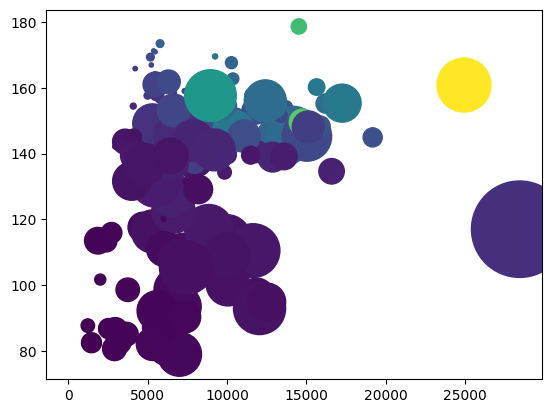

In [19]:
import matplotlib.pyplot as plt

plt.scatter(df_analyse_1['distance'], df_analyse_1['average_heartrate'], c=df_analyse_1['suffer_score'], s=df_analyse_1['total_elevation_gain']*2)
plt.show()

In [20]:
df_low_intensity = df_analyse_1[df_analyse_1['Zone 2'] / (df_analyse_1['Zone 1'] + df_analyse_1['Zone 2'] + df_analyse_1['Zone 3'] + df_analyse_1['Zone 4'] + df_analyse_1['Zone 5']) > 0.80]

df_low_intensity = df_low_intensity.copy()
df_low_intensity['ratio zone 2'] = (df_analyse_1['Zone 1'] + df_analyse_1['Zone 2']) / (df_analyse_1['Zone 1'] + df_analyse_1['Zone 2'] + df_analyse_1['Zone 3'] + df_analyse_1['Zone 4'] + df_analyse_1['Zone 5'])
df_low_intensity

,id,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5,distance,moving_time,total_elevation_gain,sport_type,start_date,average_speed,average_heartrate,suffer_score,activity_num,distance + d+,standardize_score,ratio zone 2
5,2002867821,43,1744,0,0,0,5475.7,29.783333,11.9,Run,29/11/2018,3.064,138.9,17.0,Run 5,5594.7,0.303859,1.0
9,2015461240,55,1718,158,2,0,4813.8,32.216667,12.9,Run,13/12/2018,2.490,136.9,17.0,Run 9,4942.8,0.343935,0.917227
14,2175096564,135,3884,137,6,0,9848.3,69.983333,48.2,Run,25/02/2019,2.345,134.3,26.0,Run 14,10330.3,0.251687,0.965642
19,2239420452,22,2930,128,6,0,10108.7,51.433333,33.0,Run,25/03/2019,3.276,145.5,58.0,Run 19,10438.7,0.555625,0.956578
59,6274266924,59,1989,22,0,0,5212.3,34.916667,46.6,Run,18/11/2021,2.488,140.0,14.0,Run 59,5678.3,0.246553,0.989372
65,7504101773,123,2368,0,0,0,5736.3,41.900000,45.4,Run,21/07/2022,2.282,131.3,10.0,Run 65,6190.3,0.161543,1.0
67,7527677630,73,2692,0,0,0,7301.6,46.650000,5.2,Run,25/07/2022,2.609,135.5,12.0,Run 67,7353.6,0.163185,1.0
76,8441204171,297,3505,0,0,0,2509.9,63.366667,0.0,Run,23/01/2023,0.660,131.5,16.0,Run 76,2509.9,0.637476,1.0
104,9880184467,83,2843,53,0,0,7376.3,49.900000,7.5,Run,19/09/2023,2.464,136.8,16.0,Run 104,7451.3,0.214728,0.982209
113,10365813857,179,2294,0,0,0,5980.6,41.216667,37.1,Run,11/12/2023,2.418,133.6,11.0,Run 113,6351.6,0.173185,1.0


In [21]:
df_low_intensity['Month_YY'] = pd.to_datetime(df_low_intensity['start_date']).dt.strftime('%Y%m')
df_low_intensity


/var/folders/9b/4nn2l_vj2p1cqjzqd_j4kvf80000gn/T/ipykernel_39653/207266361.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_low_intensity['Month_YY'] = pd.to_datetime(df_low_intensity['start_date']).dt.strftime('%Y%m')


,id,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5,distance,moving_time,total_elevation_gain,sport_type,start_date,average_speed,average_heartrate,suffer_score,activity_num,distance + d+,standardize_score,ratio zone 2,Month_YY
5,2002867821,43,1744,0,0,0,5475.7,29.783333,11.9,Run,29/11/2018,3.064,138.9,17.0,Run 5,5594.7,0.303859,1.0,201811
9,2015461240,55,1718,158,2,0,4813.8,32.216667,12.9,Run,13/12/2018,2.490,136.9,17.0,Run 9,4942.8,0.343935,0.917227,201812
14,2175096564,135,3884,137,6,0,9848.3,69.983333,48.2,Run,25/02/2019,2.345,134.3,26.0,Run 14,10330.3,0.251687,0.965642,201902
19,2239420452,22,2930,128,6,0,10108.7,51.433333,33.0,Run,25/03/2019,3.276,145.5,58.0,Run 19,10438.7,0.555625,0.956578,201903
59,6274266924,59,1989,22,0,0,5212.3,34.916667,46.6,Run,18/11/2021,2.488,140.0,14.0,Run 59,5678.3,0.246553,0.989372,202111
65,7504101773,123,2368,0,0,0,5736.3,41.900000,45.4,Run,21/07/2022,2.282,131.3,10.0,Run 65,6190.3,0.161543,1.0,202207
67,7527677630,73,2692,0,0,0,7301.6,46.650000,5.2,Run,25/07/2022,2.609,135.5,12.0,Run 67,7353.6,0.163185,1.0,202207
76,8441204171,297,3505,0,0,0,2509.9,63.366667,0.0,Run,23/01/2023,0.660,131.5,16.0,Run 76,2509.9,0.637476,1.0,202301
104,9880184467,83,2843,53,0,0,7376.3,49.900000,7.5,Run,19/09/2023,2.464,136.8,16.0,Run 104,7451.3,0.214728,0.982209,202309
113,10365813857,179,2294,0,0,0,5980.6,41.216667,37.1,Run,11/12/2023,2.418,133.6,11.0,Run 113,6351.6,0.173185,1.0,202312


In [22]:
df_intensity = df_analyse_1.copy()

col_to_keep = ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5', 'distance', 'moving_time', 'average_speed', 'id','start_date']

df_intensity = df_intensity[col_to_keep]

df_intensity['Zone 2'] = df_intensity['Zone 2'] * 2
df_intensity['Zone 3'] = df_intensity['Zone 3'] * 2.5
df_intensity['Zone 4'] = df_intensity['Zone 4'] * 4
df_intensity['Zone 5'] = df_intensity['Zone 5'] * 5
df_intensity['moving_time'] = df_intensity['Zone 1'] + df_intensity['Zone 2'] + df_intensity['Zone 3'] + df_intensity['Zone 4'] + df_intensity['Zone 5']
df_intensity['start_date'] = pd.to_datetime(df_intensity['start_date'], format='%d/%m/%Y').dt.strftime('%Y/%m')
df_intensity['distance ~ intensity'] = (df_intensity['moving_time']) * df_intensity['average_speed']
df_intensity

,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5,distance,moving_time,average_speed,id,start_date,distance ~ intensity
0,21,818,2722.5,1964,310,5851.9,5835.5,2.824,2002867793,2018/11,16479.452
1,48,2238,1935.0,1324,0,6501.4,5545.0,2.834,2002867790,2018/11,15714.53
2,18,440,3437.5,2940,120,6627.0,6955.5,2.784,2002867807,2018/11,19364.112
3,10,658,3010.0,1388,0,5000.3,5066.0,2.626,2002867788,2018/11,13303.316
4,23,928,2607.5,3536,40,7741.6,7134.5,3.196,2002867794,2018/11,22801.862
...,...,...,...,...,...,...,...,...,...,...,...
200,3,320,6950.0,12388,205,12412.5,19866.0,1.855,11283321967,2024/04,36851.43
201,6763,0,0.0,0,0,12510.8,6763.0,0.837,11286914386,2024/04,5660.631
202,1378,3462,827.5,0,0,8191.7,5667.5,2.379,11302270681,2024/04,13482.9825
203,815,1438,3695.0,68,0,4786.2,6016.0,0.980,11309723351,2024/05,5895.68


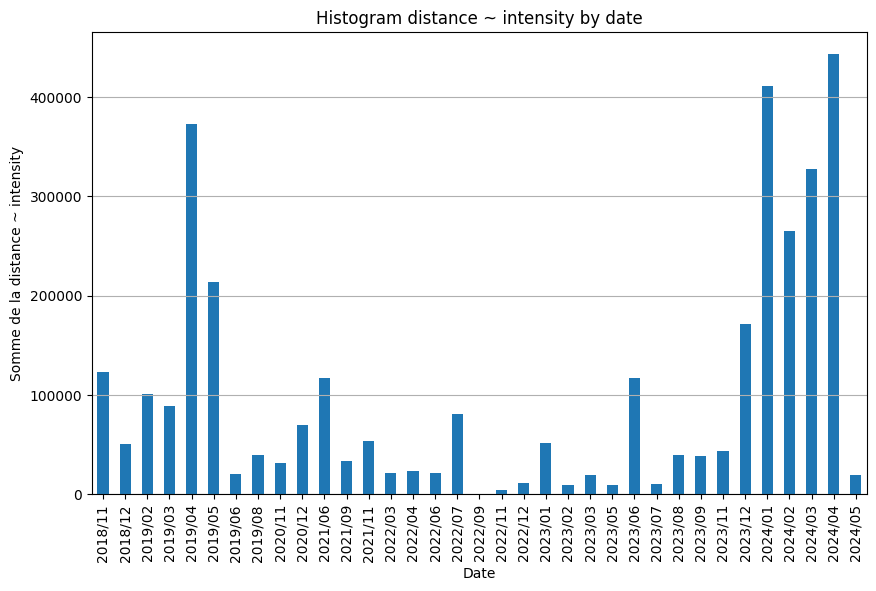

In [23]:
grouped_by_date = df_intensity.groupby(df_intensity['start_date'])['distance ~ intensity'].sum().sort_values(ascending=True)
grouped_sorted = grouped_by_date.sort_index()

grouped_sorted.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Somme de la distance ~ intensity')
plt.title('Histogram distance ~ intensity by date')
plt.xticks(rotation=90)  
plt.grid(axis='y')
plt.show()